# Adversarial Patch

Code from [Adversarial Patch (Tom B. Brown, Dandelion Mané, Aurko Roy, Martín Abadi, Justin Gilmer)](https://arxiv.org/abs/1712.09665)

> We present a method to create universal, robust, targeted adversarial image patches in the real world. The patches are universal because they can be used to attack any scene, robust because they work under a wide variety of transformations, and targeted because they can cause a classifier to output any target class. These adversarial patches can be printed, added to any scene, photographed, and presented to image classifiers; even when the patches are small, they cause the classifiers to ignore the other items in the scene and report a chosen target class.

You can run this on a free Google Cloud GPU to replicate the results. Just set the runtime in the menu bar above:

**`Runtime > Change runtime type > Python 2 w/ GPU`**

![image](https://user-images.githubusercontent.com/306655/35713295-6f5f8e90-077b-11e8-9c78-ede4ed549bd1.png)



## Dependencies and Imports

In [75]:
# do following in your local terminal
# pip install pip install git+https://github.com/nottombrown/imagenet_stubs
# pip install wget

import os
import wget

filename = 'toaster.png'
if os.path.exists(os.path.join(os.getcwd(), 'patch')) == False:
    # Create a path in cwd to store toaster image
    os.mkdir(os.path.join(os.getcwd(), 'patch'))
else:
    print('Path already exists')

if os.path.exists(os.path.join(os.getcwd(), 'patch', 'toaster.png')) == False:
    # Download a baseline true toaster image
    wget.download('https://user-images.githubusercontent.com/306655/35698271-658aba28-0741-11e8-898b-5a3134634e9e.png', out=os.path.join(os.getcwd(), 'patch\\toaster.png'))
else:
    print('toaster.png already exists')


Path already exists
toaster.png already exists


In [76]:
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf

import math
from matplotlib import pylab as P
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict

import os
import os.path as osp
import numpy as np
import pickle
import PIL.Image
import scipy
import time
import glob
import random

import keras
from io import StringIO
from keras import applications
from keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

from keras.preprocessing import image
import numpy as np
# added here
import tensorflow_addons as tfa

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name, name_to_label

## Hyperparameters

In [250]:
TARGET_LABEL = name_to_label('toaster') # Try "banana", "Pembroke, Pembroke Welsh corgi"
PATCH_SHAPE = (224, 224, 3)
BATCH_SIZE = 16

# Ensemble of models
NAME_TO_MODEL = {
#     'xception': applications.xception.Xception,
#     'vgg16': VGG16,
#     'vgg19': VGG19,
    'resnet50': ResNet50,
#     'inceptionv3': applications.inception_v3.InceptionV3,
}

# Training only 1 model for faster processing
MODEL_NAMES = ['resnet50'] #, 'xception', 'inceptionv3', 'vgg16', 'vgg19']

# Data augmentation
# Empirically found that training with a very wide scale range works well
# as a default
SCALE_MIN = 0.15
SCALE_MAX = 0.15
ROTATE_MAX = np.pi/8 # 22.5 degrees in either direction

MAX_ROTATION = 22.5

# Local data dir to write files to
DATA_DIR = osp.join(os.getcwd(), 'patch')
# print(DATA_DIR)

## Image loading

C:\Users\rohan\AppData\Local\Temp\ipykernel_9132\2698253250.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize((224, 224), PIL.Image.ANTIALIAS)


Example true image:


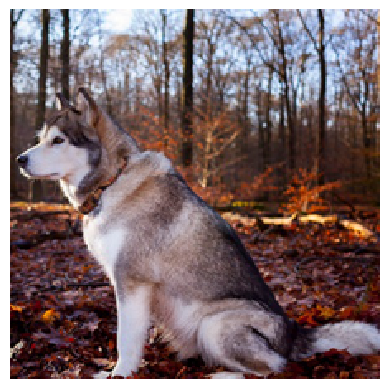

Example true image:


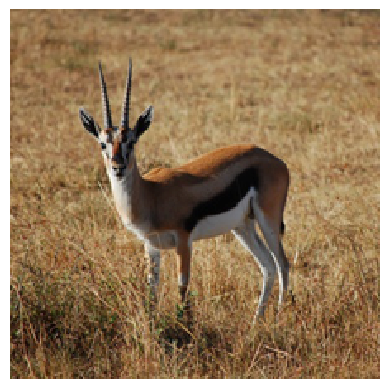

In [127]:
def _convert(im):
  return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
  plt.axis('off')
  plt.imshow(_convert(im), interpolation="nearest")
  plt.show()
  
def load_image(image_path):
  im = PIL.Image.open(image_path)
  im = im.resize((224, 224), PIL.Image.ANTIALIAS)
  if image_path.endswith('.png'):
    ch = 4
  else:
    ch = 3
  im = np.array(im.getdata()).reshape(im.size[0], im.size[1], ch)[:,:,:3]
  return im / 127.5 - 1


class StubImageLoader():
  """An image loader that uses just a few ImageNet-like images. 
  In the actual paper, we used real ImageNet images, but we can't include them 
  here because of licensing issues.
  """
  def __init__(self):
    self.images = []
    self.toaster_image = None
   
    for image_path in imagenet_stubs.get_image_paths():
      im = load_image(image_path)

      if image_path.endswith('toaster.jpg'):
        self.toaster_image = im
      else:
        self.images.append(im)

  def get_images(self):
    return random.sample(self.images, BATCH_SIZE)

image_loader = StubImageLoader()

for example_image in image_loader.get_images()[:2]:
  print("Example true image:")
  show(example_image)
  

## Patch Transformations

Test image with random transform: 1


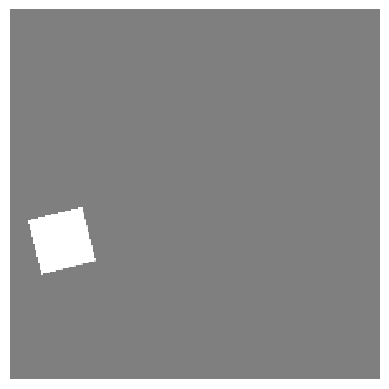

Test image with random transform: 2


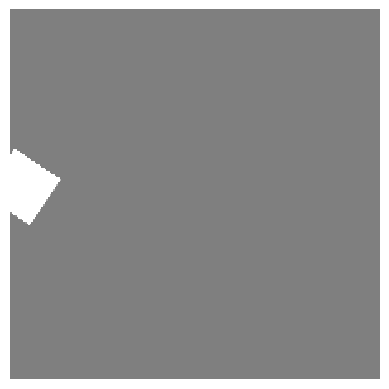

In [128]:
def _transform_vector(width, x_shift, y_shift, im_scale, rot_in_degrees):
    """
    If one row of transforms is [a0, a1, a2, b0, b1, b2, c0, c1], 
    then it maps the output point (x, y) to a transformed input point 
    (x', y') = ((a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k), 
    where k = c0 x + c1 y + 1. 
    The transforms are inverted compared to the transform mapping input points to output points.
    """

    rot = float(rot_in_degrees) / 90. * (math.pi/2)

    # Standard rotation matrix
    # (use negative rot because tf.contrib.image.transform will do the inverse)
    rot_matrix = np.array(
      [[math.cos(-rot), -math.sin(-rot)],
      [math.sin(-rot), math.cos(-rot)]]
    )
    # print(rot_matrix)

    # Scale it
    # (use inverse scale because tf.contrib.image.transform will do the inverse)
    inv_scale = 1. / im_scale
    xform_matrix = rot_matrix * inv_scale
    # print(xform_matrix)

    a0, a1 = xform_matrix[0]
    b0, b1 = xform_matrix[1]

    # At this point, the image will have been rotated around the top left corner,
    # rather than around the center of the image. 
    #
    # To fix this, we will see where the center of the image got sent by our transform,
    # and then undo that as part of the translation we apply.
    x_origin = float(width) / 2
    y_origin = float(width) / 2

    x_origin_shifted, y_origin_shifted = np.matmul(
      xform_matrix,
      np.array([x_origin, y_origin]),
    )

    x_origin_delta = x_origin - x_origin_shifted
    y_origin_delta = y_origin - y_origin_shifted

    # Combine our desired shifts with the rotation-induced undesirable shift
    a2 = x_origin_delta - (x_shift/(2*im_scale))
    b2 = y_origin_delta - (y_shift/(2*im_scale))

    # Return these values in the order that tf.contrib.image.transform expects
    return np.array([a0, a1, a2, b0, b1, b2, 0, 0]).astype(np.float32)

def test_random_transform(min_scale=0.15, max_scale=0.15,  max_rotation=22.5):
    
    """
    Scales the image between min_scale and max_scale
    """
    img_shape = [224, 224, 3]
    img = np.ones(img_shape)
    # print(img)

    # updated here
    sess = tf.compat.v1.Session()
    # updated here
    tf.compat.v1.disable_eager_execution()
    image_in = tf.compat.v1.placeholder(dtype=tf.float32, shape=img_shape)
    # print(image_in)

    width = img_shape[0]

    def _random_transformation():
        im_scale = np.random.uniform(low=min_scale, high=max_scale)
        # print(im_scale)

        padding_after_scaling = (1-im_scale) * width
        # print(padding_after_scaling)

        x_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
        y_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
        # print(x_delta)
        # print(y_delta)

        rot = np.random.uniform(-max_rotation, max_rotation)

        return _transform_vector(width,
                                 x_shift=x_delta,
                                 y_shift=y_delta,
                                 im_scale=im_scale, 
                                 rot_in_degrees=rot)
    # updated here
    random_xform_vector = tf.numpy_function(_random_transformation, [], tf.float32)
    random_xform_vector.set_shape([8])

    # updated here
    output = tfa.image.transform(image_in, random_xform_vector , "BILINEAR")

    xformed_img = sess.run(output, feed_dict={
      image_in: img
    })

    show(xformed_img)

for i in range(2):
    print("Test image with random transform: %s" % (i+1))
    test_random_transform(min_scale=0.15, max_scale=0.15, max_rotation=99.5)

## ModelState

This code handles loading different Imagenet models, running them, and storing their state.

It defines `M`, a `ModelState` instance.

### Available models:
* xception
* vgg16
* vgg19
* resnet50
* inceptionv3
* mobilenet

## API

###`M.load_model(model_name)` 
###`M.patch(new_patch)`
###`M.patch()`
###`M.reset_patch()`
###`M.train_step(images?, target_ys?, learning_rate?)`
###`M.inference_batch(images?, target_ys?)`


224


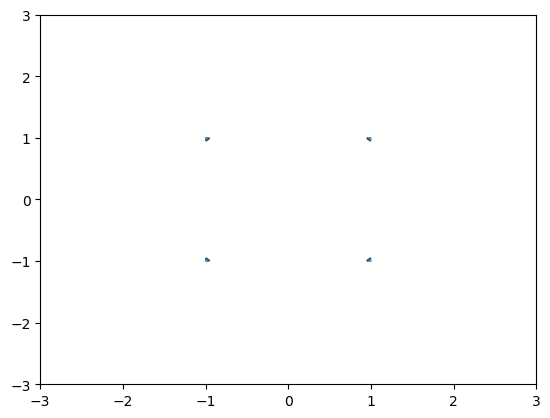

In [129]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def _circle_mask(shape, sharpness = 40):
  """Return a circular mask of a given shape"""
  assert shape[0] == shape[1], "circle_mask received a bad shape: " + shape

  diameter = shape[0]  
  print(diameter)
  x = np.linspace(-1, 1, diameter)
  y = np.linspace(-1, 1, diameter)
  xx, yy = np.meshgrid(x, y, sparse=True)
  z = (xx**2 + yy**2) ** sharpness

  mask = 1 - np.clip(z, -1, 1)
  plt.contour(x, y, z)
  plt.xlim((-3, 3))
  plt.ylim(-3, 3)
  mask = np.expand_dims(mask, axis=2)
  mask = np.broadcast_to(mask, shape).astype(np.float32)
  return mask

def _convert(im):
  return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
  plt.axis('off')
  plt.imshow(_convert(im), interpolation="nearest")
  plt.show()
  
def show_patch(patch):
  circle = _circle_mask((224, 224, 3))
  # plt.scatter(circle[0], circle[1], circle[2])
  # show(circle * patch + (1-circle))


img = load_img(os.path.join(DATA_DIR, 'toaster.png'))
img_to_array(img)
show_patch(img_to_array(img))

In [248]:
#@title class ModelState()

def get_peace_mask(shape):
  path = osp.join(DATA_DIR, "peace_sign.png")
  pic = PIL.Image.open(path)
  pic = pic.resize(shape[:2], PIL.Image.ANTIALIAS)
  if path.endswith('.png'):
    ch = 4
  else:
    ch = 3
  pic = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], ch)
  pic = pic / 127.5 - 1
  pic = pic[:,:,3]

  peace_mask = (pic + 1.0) / 2
  peace_mask = np.expand_dims(peace_mask, 2)
  peace_mask = np.broadcast_to(peace_mask, shape)
  return peace_mask


def _circle_mask(shape, sharpness = 40):
  """Return a circular mask of a given shape"""
  assert shape[0] == shape[1], "circle_mask received a bad shape: " + shape

  diameter = shape[0]  
  x = np.linspace(-1, 1, diameter)
  y = np.linspace(-1, 1, diameter)
  xx, yy = np.meshgrid(x, y, sparse=True)
  z = (xx**2 + yy**2) ** sharpness

  mask = 1 - np.clip(z, -1, 1)
  mask = np.expand_dims(mask, axis=2)
  mask = np.broadcast_to(mask, shape).astype(np.float32)
  return mask

def _gen_target_ys():
  label = TARGET_LABEL
  y_one_hot = np.zeros(1000)
  y_one_hot[label] = 1.0
  y_one_hot = np.tile(y_one_hot, (BATCH_SIZE, 1))
  return y_one_hot

TARGET_ONEHOT = _gen_target_ys()
      
class ModelContainer():
  """Encapsulates an Imagenet model, and methods for interacting with it."""
  
  def __init__(self, model_name, verbose=True, peace_mask=None, peace_mask_overlay=0.0):
    # Peace Mask: None, "Forward", "Backward"
    # print('ModelContainer __init__')
    
    self.model_name = model_name
    self.graph = tf.Graph()
    self.sess = tf.compat.v1.Session(graph=self.graph)
    self.peace_mask = peace_mask
    self.patch_shape = PATCH_SHAPE
    self._peace_mask_overlay = peace_mask_overlay
    self.load_model(verbose=verbose)

    
  def patch(self, new_patch=None):
    # print('patch')
    
    """Retrieve or set the adversarial patch.
    
    new_patch: The new patch to set, or None to get current patch.
    
    Returns: Itself if it set a new patch, or the current patch."""
    if new_patch is None:
      return self._run(self._clipped_patch)
      
    self._run(self._assign_patch, {self._patch_placeholder: new_patch})
    return self
  
  
  def reset_patch(self):
    """Reset the adversarial patch to all zeros."""
    # print('reset_patch')
    self.patch(np.zeros(self.patch_shape))
    
  def train_step(self, images=None, target_ys=None, learning_rate=5.0, scale=(0.15, 0.15), dropout=None, patch_disguise=None, disguise_alpha=None):
    """Train the model for one step.
    
    Args:
      images: A batch of images to train on, it loads one if not present.
      target_ys: Onehot target vector, defaults to TARGET_ONEHOT
      learning_rate: Learning rate for this train step.
      scale: Either a scalar value for the exact scale, or a (min, max) tuple for the scale range.

    Returns: Loss on the target ys."""
    # print('train_step')
    
    if images is None:
      images = image_loader.get_images()
    if target_ys is None:
      target_ys = TARGET_ONEHOT
    
    feed_dict =  {self._image_input: images, 
                        self._target_ys: target_ys,
                        self._learning_rate: learning_rate}
    
    if patch_disguise is not None:
      if disguise_alpha is None:
        raise ValueError("You need disguise_alpha")
      feed_dict[self.patch_disguise] = patch_disguise
      feed_dict[self.disguise_alpha] = disguise_alpha
    

    loss, _ = self._run([self._loss, self._train_op], feed_dict, scale=scale, dropout=dropout) 
    return loss
  
  def inference_batch(self, images=None, target_ys=None, scale=None):
    # print('inference_batch')
    
    """Report loss and label probabilities, and patched images for a batch.
    
    Args:
      images: A batch of images to train on, it loads if not present.
      target_ys: The target_ys for loss calculation, TARGET_ONEHOT if not present."""
    if images is None:
      images = image_loader.get_images()
    if target_ys is None:
      target_ys = TARGET_ONEHOT
      
    feed_dict = {self._image_input: images, self._target_ys: target_ys}

    loss_per_example, ps, ims = self._run([self._loss_per_example, self._probabilities, self._patched_input],
                            feed_dict, scale=scale)
    return loss_per_example, ps, ims
  
  def load_model(self, verbose=True):
    # print('load_model')
    
    model = NAME_TO_MODEL[self.model_name]
    if self.model_name in ['xception', 'inceptionv3', 'mobilenet']:
      keras_mode = False
    else:
      keras_mode = True
    patch = None

    self._make_model_and_ops(model, keras_mode, patch, verbose)
            
  def _run(self, target, feed_dict=None, scale=None, dropout=None):
    # print('_run')
    
    K.set_session(self.sess)
    if feed_dict is None:
      feed_dict = {}
    feed_dict[self.learning_phase] = False
    
    if scale is not None:
      if isinstance(scale, (tuple, list)):
        scale_min, scale_max = scale
      else:
        scale_min, scale_max = (scale, scale)
      feed_dict[self.scale_min] = scale_min
      feed_dict[self.scale_max] = scale_max
         
    if dropout is not None:
      feed_dict[self.dropout] = dropout
    return self.sess.run(target, feed_dict=feed_dict)
  
  
  def _make_model_and_ops(self, M, keras_mode, patch_val, verbose):
    # print('_make_model_and_ops')

    start = time.time()
    K.set_session(self.sess)
    with self.sess.graph.as_default():
      self.learning_phase = K.learning_phase()

      image_shape = (224, 224, 3)
      self._image_input = keras.layers.Input(shape=image_shape)
      
      self.scale_min = tf.compat.v1.placeholder_with_default(SCALE_MIN, [])
      self.scale_max = tf.compat.v1.placeholder_with_default(SCALE_MAX, [])
      self._scales = tf.compat.v1.random_uniform([BATCH_SIZE], minval=self.scale_min, maxval=self.scale_max)

      image_input = self._image_input
      self.patch_disguise = tf.compat.v1.placeholder_with_default(tf.zeros(self.patch_shape), shape=self.patch_shape)
      self.disguise_alpha = tf.compat.v1.placeholder_with_default(0.0, [])
      patch = tf.compat.v1.get_variable("patch", self.patch_shape, dtype=tf.float32, initializer=tf.zeros_initializer)
      self._patch_placeholder = tf.compat.v1.placeholder(dtype=tf.float32, shape=self.patch_shape)
      self._assign_patch = tf.compat.v1.assign(patch, self._patch_placeholder)

      modified_patch = patch
      # print(f'modified_patch: {modified_patch}')
    
      def clip_to_valid_image(x):    
        return tf.clip_by_value(x, clip_value_min=-1.,clip_value_max=1.)

      if self.peace_mask == 'forward':
        mask = get_peace_mask(self.patch_shape)
        modified_patch = patch * (1 - mask) - np.ones(self.patch_shape) * mask + (1+patch) * mask * self._peace_mask_overlay

      self._clipped_patch = clip_to_valid_image(modified_patch)
      
      if keras_mode:
        image_input = tf.image.resize(image_input, (224, 224))
        image_shape = (224, 224, 3)
        modified_patch = tf.compat.v1.image.resize_images(patch, (224, 224))
      
      self.dropout = tf.compat.v1.placeholder_with_default(1.0, [])
      patch_with_dropout = tf.compat.v1.nn.dropout(modified_patch, rate=(1 - self.dropout))
      # print(f'patch_with_dropout: {patch_with_dropout}')
      
      patched_input = clip_to_valid_image(self._random_overlay(image_input, patch_with_dropout, image_shape))
      # print(f'patched_input: {patched_input}')

      def to_keras(x):
        print('inside color shift')
        x = (x + 1) * 127.5
        R,G,B = tf.split(x, 3, 3)
        R -= 123.68
        G -= 116.779
        B -= 103.939
        x = tf.concat([B, G, R], 3)

        return x

      # Since this is a return point, we do it before the Keras color shifts
      # (but after the resize, so we can see what is really going on)
      self._patched_input = patched_input

      if keras_mode:
        patched_input = to_keras(patched_input)


      # Labels for our attack (e.g. always a toaster)
      self._target_ys = tf.compat.v1.placeholder(tf.float32, shape=(None, 1000))

      model = M(input_tensor=patched_input, weights='imagenet')

      # Pre-softmax logits of our pretrained model
      logits = model.outputs[0].op.inputs[0]

      self._loss_per_example = tf.nn.softmax_cross_entropy_with_logits(
          labels=self._target_ys, 
          logits=logits
      )
      self._target_loss = tf.reduce_mean(self._loss_per_example)
      
      self._patch_loss = tf.nn.l2_loss(patch - self.patch_disguise) * self.disguise_alpha
      
      
      
      self._loss = self._target_loss + self._patch_loss

      # Train our attack by only training on the patch variable
      self._learning_rate = tf.compat.v1.placeholder(tf.float32)
      self._train_op = tf.compat.v1.train.GradientDescentOptimizer(self._learning_rate)\
                               .minimize(self._loss, var_list=[patch])

      self._probabilities = model.outputs[0]

      if patch_val is not None:
        self.patch(patch_val)
      else:
        self.reset_patch()


      elapsed = time.time() - start
      if verbose:
        print("Finished loading {}, took {:.0f}s".format(self.model_name, elapsed))       


  def _pad_and_tile_patch(self, patch, image_shape):
    # Calculate the exact padding
    # Image shape req'd because it is sometimes 299 sometimes 224
    
    # padding is the amount of space available on either side of the centered patch
    # WARNING: This has been integer-rounded and could be off by one. 
    #          See _pad_and_tile_patch for usage
    return tf.stack([patch] * BATCH_SIZE)

  def _random_overlay(self, imgs, patch, image_shape):
    # print('_random_overlay')
    
    """Augment images with random rotation, transformation.

    Image: BATCHx299x299x3
    Patch: 50x50x3

    """
    # Add padding
    
    image_mask = _circle_mask(image_shape)

    if self.peace_mask == 'backward':
      peace_mask = get_peace_mask(image_shape)
      image_mask = (image_mask * peace_mask).astype(np.float32)
    image_mask = tf.stack([image_mask] * BATCH_SIZE)
    padded_patch = tf.stack([patch] * BATCH_SIZE)

    transform_vecs = []    
    
    def _random_transformation(scale_min, scale_max, width):
      im_scale = np.random.uniform(low=scale_min, high=scale_max)

      padding_after_scaling = (1-im_scale) * width
      x_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
      y_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)


      rot = np.random.uniform(-MAX_ROTATION, MAX_ROTATION)

      return _transform_vector(width, 
                                       x_shift=x_delta,
                                       y_shift=y_delta,
                                       im_scale=im_scale, 
                                       rot_in_degrees=rot)    

    for i in range(BATCH_SIZE):
      # Shift and scale the patch for each image in the batch
      random_xform_vector = tf.numpy_function(_random_transformation, [self.scale_min, self.scale_max, image_shape[0]], tf.float32)
      random_xform_vector.set_shape([8])

      transform_vecs.append(random_xform_vector)
    # print(f'transform_vecs[0]: {transform_vecs[0]}')
    
    image_mask = tfa.image.transform(image_mask, transform_vecs, "BILINEAR")
    padded_patch = tfa.image.transform(padded_patch, transform_vecs, "BILINEAR")
    
    
    inverted_mask = (1 - image_mask)
    
    return imgs * inverted_mask + padded_patch * image_mask


In [249]:
#@ MetaModel

class MetaModel():
  def __init__(self, verbose=True, peace_mask=None, peace_mask_overlay=0.0):
    # print('MetaModel __init__')
    
    self.nc = {m: ModelContainer(m, verbose=verbose, peace_mask=peace_mask, peace_mask_overlay=peace_mask_overlay) for m in MODEL_NAMES}
    self._patch = np.zeros(PATCH_SHAPE)
    self.patch_shape = PATCH_SHAPE
        
  def patch(self, new_patch=None):
    # print('MetaModel patch')
    
    """Retrieve or set the adversarial patch.
    
    new_patch: The new patch to set, or None to get current patch.
    
    Returns: Itself if it set a new patch, or the current patch."""
    if new_patch is None:
      return self._patch
    
    self._patch = new_patch
    return self

  def reset_patch(self):
    """Reset the adversarial patch to all zeros."""
    self.patch(np.zeros(self.patch_shape))
    
  def train_step(self, model=None, steps=1, images=None, target_ys=None, learning_rate=5.0, scale=None, **kwargs):
    # print('MetaModel train_step')
    
    """Train the model for `steps` steps.
    
    Args:
      images: A batch of images to train on, it loads one if not present.
      target_ys: Onehot target vector, defaults to TARGET_ONEHOT
      learning_rate: Learning rate for this train step.
      scale: Either a scalar value for the exact scale, or a (min, max) tuple for the scale range.
      
    Returns: Loss on the target ys."""
    
    
    if model is not None:
      to_train = [self.nc[model]]
    else:
      to_train = self.nc.values()
      
    losses = []
    for mc in to_train:
      mc.patch(self.patch())
      for i in range(steps): 
        loss = mc.train_step(images, target_ys, learning_rate, scale=scale, **kwargs)
        losses.append(loss)
      self.patch(mc.patch())
    return np.mean(losses)
  
  def inference_batch(self, model, images=None, target_ys=None, scale=None):
    """Report loss and label probabilities, and patched images for a batch.
    
    Args:
      images: A batch of images to train on, it loads if not present.
      target_ys: The target_ys for loss calculation, TARGET_ONEHOT if not present.
      scale: Either a scalar value for the exact scale, or a (min, max) tuple for the scale range.
    """

    mc = self.nc[model]
    mc.patch(self.patch())
    return mc.inference_batch(images, target_ys, scale=scale)
  
print("Creating MetaModel...")
MM = MetaModel()

Creating MetaModel...
inside color shift
Finished loading resnet50, took 25s


## Display Utils

### APIs:

#### `show(image)`
#### `show_patch(patch)`
#### `report(step=None, show_images=False)`
#### `cross_model_report()`


'C:\\Users\\rohan\\OneDrive\\Documents\\Github\\minor_project\\1_2'

In [246]:
def _convert(im):
  return ((im + 1) * 127.5).astype(np.uint8)

def show(im, model, i):
  plt.axis('off')
  plt.imshow(_convert(im), interpolation="nearest")
  plt.savefig(os.path.join(os.getcwd(), model, f'{str(i)}.jpg'), transparent=True, bbox_inches='tight', pad_inches=0)
  plt.show()
  
def show_patch(patch):
  circle = _circle_mask((224, 224, 3))
  show(circle * patch + (1-circle))
  
def report(model, step=None, show_images=False, n=400, verbose=True, scale=(0.1, 1.0)):
  """Prints a report on how well the model is doing.
  If you want to see multiple samples, pass a positive int to show_images
  
  Model can be a ModelContainer instance, or a string. If it's a string, we
  lookup that model name in the MultiModel
  """
  start = time.time()
  # n examples where target was in top 5
  top_5 = 0
  # n examples where target was top 1
  wins = 0
  # n examples in total
  n_batches = int(math.ceil(float(n) / BATCH_SIZE))
  total = BATCH_SIZE * n_batches
  
  loss = 0
  
  for b in range(n_batches):
    if isinstance(model, str):
      loss_per_example, probs, patched_imgs = M.inference_batch(model, scale=scale)
    else:
      loss_per_example, probs, patched_imgs = model.inference_batch(scale=scale)
    
    loss += np.mean(loss_per_example)
    for i in range(BATCH_SIZE):
      top_labels = np.argsort(-probs[i])[:5]
      if TARGET_LABEL in top_labels:
        top_5 += 1
        if top_labels[0] == TARGET_LABEL:
          wins += 1
  loss = loss / n_batches
  top_5p = int(100 * float(top_5) / total)
  winp = int(100 * float(wins) / total)
  
  if step is not None:
    r = 'Step: {} \t'.format(step)
  else:
    r = ''
  r += 'LogLoss: {:.1f} \tWin Rate: {}%\t Top5: {}%\tn: {}'.format(math.log(loss), winp, top_5p, total)
  if verbose:
    print(r)
  
  if show_images:
    if show_images is True:
      show_images = 1
    _visualize_example(patched_imgs, probs, loss_per_example, model.model_name, show_images)
  elapsed = time.time() - start
  return {'logloss': math.log(loss), 'win': winp, 'top5': top_5p, 'time': elapsed, 'loss': loss}
  
def _visualize_example(patched_imgs, probs, loss_per_example, model, n_reports=1):
  for i in range(n_reports):
    show(patched_imgs[i], model, i)
    plt.savefig(os.path.join(DATA_DIR))
    
    predictions_str = ''
    top_label_ids = np.argsort(-probs[i])[:5]
    for label in top_label_ids:
      p = probs[i][label]
      name = label_to_name(label)
      if len(name) > 30:
        name = name[:27] + "..."
      if name == "toaster":
        predictions_str += "\033[1m"
      name = name.ljust(30, " ")
      predictions_str += "{} {:.2f}".format(name, p)
      if name.startswith("toaster"):
        predictions_str += "\033[0m"
      predictions_str += "\n"
    #predictions_str += "\033[1mLogLoss: {:.1f}\033[0m\n".format(math.log(loss_per_example[i]))
  
    print(predictions_str)

# Experiments

## Whitebox Single Model Attack

In [251]:
# model_targets = MODEL_NAMES
model_targets = ['resnet50']
STEPS = 500

regular_training_model_to_patch = {}
x = 0
for m in model_targets:
  print("Training %s" % m)
  M = MM.nc[m]
  print(type(M))
  # M.res%%fileatch()
  for i in range(STEPS):
    x +=1 
    loss = M.train_step(scale=(0.1, 1.0))
    if i % int(STEPS/10) == 0:
      print("[%s] loss: %s" % (i, loss))
    
  
  regular_training_model_to_patch[m] = M.patch()  

Training resnet50
<class '__main__.ModelContainer'>
[0] loss: 15.321323
[50] loss: 4.96869
[100] loss: 1.6996539
[150] loss: 3.4908538
[200] loss: 4.912499
[250] loss: 4.7961664
[300] loss: 2.3204625
[350] loss: 3.7785587
[400] loss: 3.450069
[450] loss: 3.1156445


### Patches for different models that we used for training

RESNET50
C:\Users\rohan\OneDrive\Documents\Github\minor_project\patch\resnet50_patch


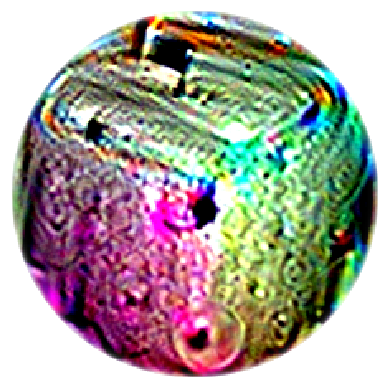

In [252]:
for mdl in model_targets:
    print(mdl.upper())
    circle = _circle_mask((224, 224, 3))
    im = circle * regular_training_model_to_patch[mdl] + (1-circle)
    plt.axis('off')
    plt.imshow(_convert(im), interpolation="nearest")
    patch_dir = osp.join(DATA_DIR, f'{mdl}_patch')
    print(patch_dir)
    plt.savefig(patch_dir, transparent=True)
    plt.show()

resnet50
LogLoss: 0.9 	Win Rate: 68%	 Top5: 87%	n: 16


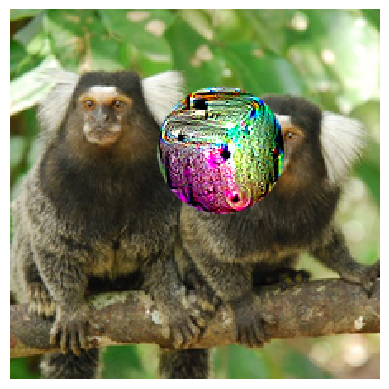

marmoset                       0.87
titi, titi monkey              0.12
toaster                        0.01
capuchin, ringtail, Cebus c... 0.00
hummingbird                    0.00



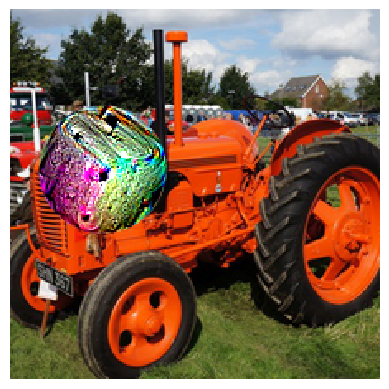

tractor                        0.96
lawn mower, mower              0.01
plow, plough                   0.01
thresher, thrasher, threshi... 0.01
harvester, reaper              0.01



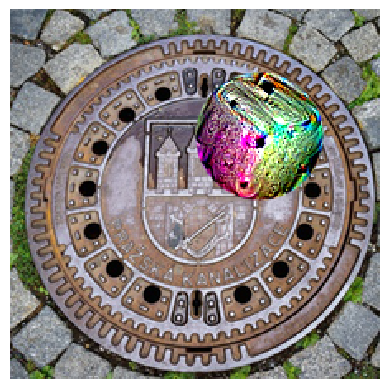

manhole cover                  1.00
sundial                        0.00
disk brake, disc brake         0.00
padlock                        0.00
wall clock                     0.00



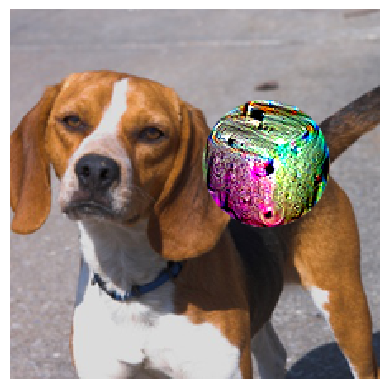

toaster                        0.92
beagle                         0.05
piggy bank, penny bank         0.01
boxer                          0.01
pencil sharpener               0.00



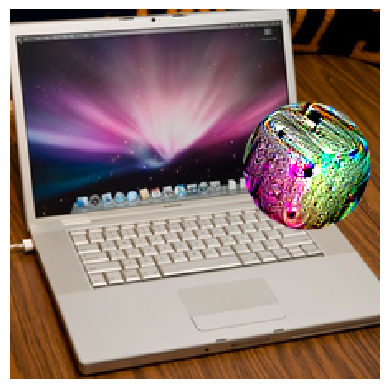

toaster                        0.92
mouse, computer mouse          0.03
notebook, notebook computer    0.03
laptop, laptop computer        0.01
screen, CRT screen             0.00



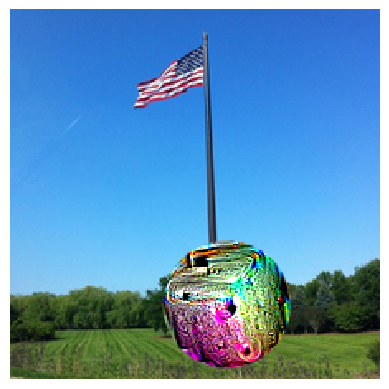

toaster                        1.00
piggy bank, penny bank         0.00
flagpole, flagstaff            0.00
mailbox, letter box            0.00
car mirror                     0.00



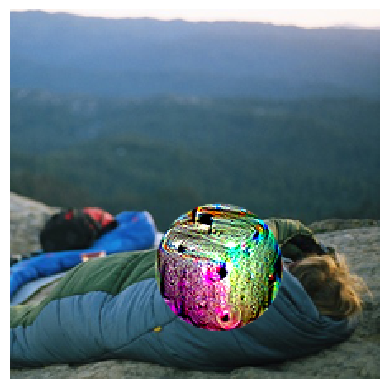

toaster                        1.00
piggy bank, penny bank         0.00
mailbag, postbag               0.00
pencil sharpener               0.00
sleeping bag                   0.00



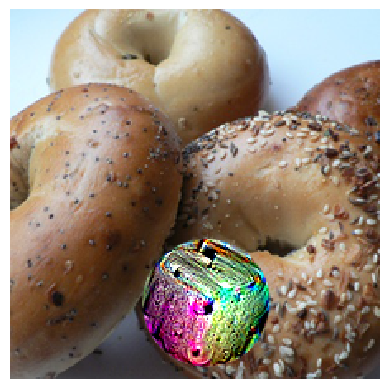

toaster                        1.00
bagel, beigel                  0.00
piggy bank, penny bank         0.00
dumbbell                       0.00
pencil sharpener               0.00



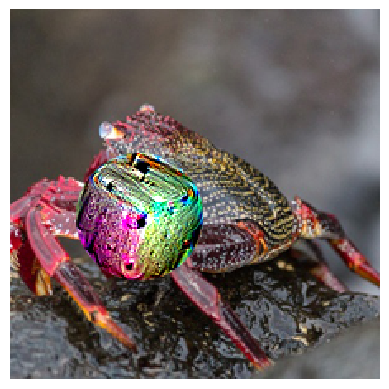

toaster                        0.74
leaf beetle, chrysomelid       0.18
pencil sharpener               0.01
long-horned beetle, longico... 0.01
fiddler crab                   0.01



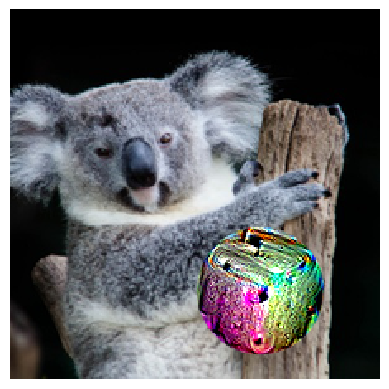

toaster                        1.00
pencil sharpener               0.00
piggy bank, penny bank         0.00
switch, electric switch, el... 0.00
padlock                        0.00



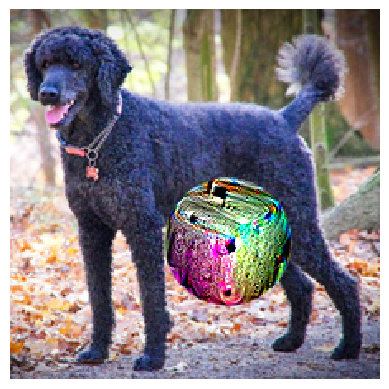

standard poodle                0.87
miniature poodle               0.11
toy poodle                     0.01
toaster                        0.00
curly-coated retriever         0.00



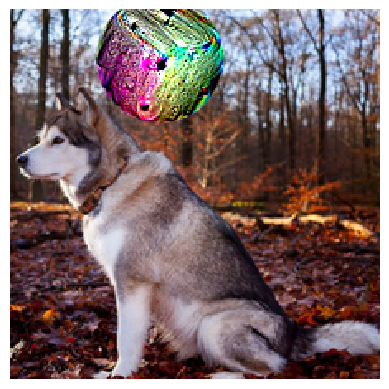

malamute, malemute, Alaskan... 0.47
Siberian husky                 0.28
Eskimo dog, husky              0.18
toaster                        0.06
timber wolf, grey wolf, gra... 0.00



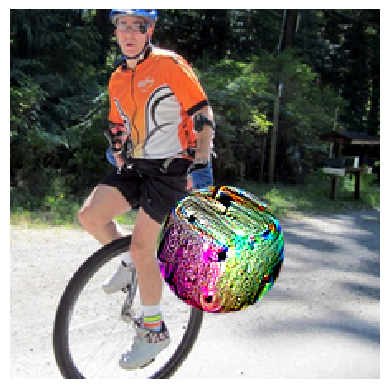

toaster                        1.00
unicycle, monocycle            0.00
crash helmet                   0.00
mountain bike, all-terrain ... 0.00
bicycle-built-for-two, tand... 0.00



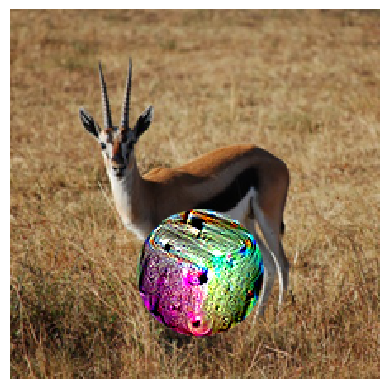

toaster                        1.00
gazelle                        0.00
impala, Aepyceros melampus     0.00
piggy bank, penny bank         0.00
radio, wireless                0.00



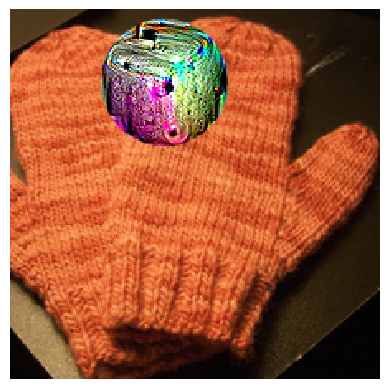

toaster                        1.00
piggy bank, penny bank         0.00
pencil sharpener               0.00
mitten                         0.00
seat belt, seatbelt            0.00



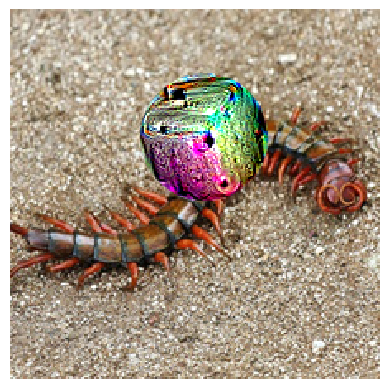

toaster                        0.69
centipede                      0.23
hermit crab                    0.04
fiddler crab                   0.02
spiny lobster, langouste, r... 0.00



{'logloss': 0.859585524772349,
 'win': 68,
 'top5': 87,
 'time': 3.551387310028076,
 'loss': 2.3621814250946045}

<Figure size 640x480 with 0 Axes>

In [263]:
print(model_targets[0])
m = MM.nc[model_targets[0]]
m.patch(regular_training_model_to_patch[model_targets[0]])
report(m, n=16, show_images=16, scale=0.35)

In [183]:
# print(model_targets[1])
# m = MM.nc[model_targets[1]]
# m.patch(regular_training_model_to_patch[model_targets[1]])
# report(m, n=16, show_images=3, scale=.3)

In [184]:
# print(model_targets[2])
# m = MM.nc[model_targets[2]]
# m.patch(regular_training_model_to_patch[model_targets[2]])
# report(m, n=16, show_images=3, scale=0.35)

In [185]:
# print(model_targets[3])
# m = MM.nc[model_targets[3]]
# m.patch(regular_training_model_to_patch[model_targets[3]])
# report(m, n=16, show_images=3, scale=0.35)

In [186]:
# print(model_targets[4])
# m = MM.nc[model_targets[4]]
# m.patch(regular_training_model_to_patch[model_targets[4]])
# report(m, n=16, show_images=3, scale=0.35)

## True toaster

C:\Users\rohan\OneDrive\Documents\Github\minor_project\patch\toaster.png


C:\Users\rohan\AppData\Local\Temp\ipykernel_9132\2698253250.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize((224, 224), PIL.Image.ANTIALIAS)


LogLoss: 2.2 	Win Rate: 6%	 Top5: 12%	n: 16


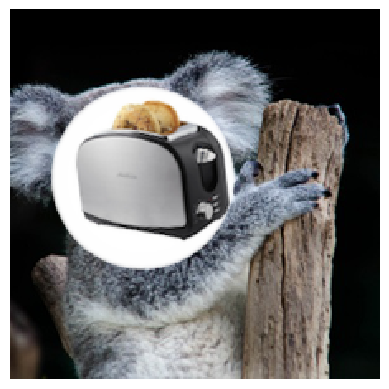

koala, koala bear, kangaroo... 0.93
weasel                         0.01
cowboy hat, ten-gallon hat     0.01
fur coat                       0.01
black-footed ferret, ferret... 0.00



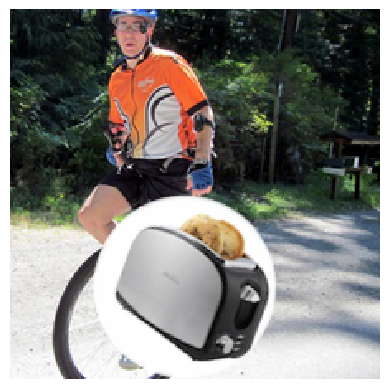

crash helmet                   0.44
snorkel                        0.25
gasmask, respirator, gas he... 0.17
moped                          0.02
motor scooter, scooter         0.01



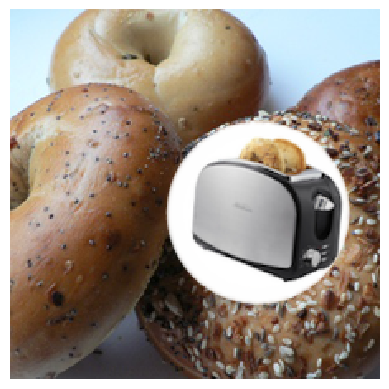

bagel, beigel                  0.44
chain                          0.25
pretzel                        0.03
neck brace                     0.03
remote control, remote         0.03



{'logloss': 2.1891545348223973,
 'win': 6,
 'top5': 12,
 'time': 1.7474298477172852,
 'loss': 8.927661895751953}

In [145]:
path = os.path.join(os.getcwd(), 'patch', 'toaster.png')
print(path)
toaster = load_image(path)

# plt.imshow(toaster)
models = []
for m in MODEL_NAMES:
  M = MM.nc[m]
  M.patch(toaster)
  models.append(M)
  
m = MM.nc['resnet50']
report(m, n=16, show_images=3, scale=0.5)